<h1>Analysis of Azog C1 chip: statistics</h1>
Online analysis script used to pre-analyse the data collected during the cooldown of the chip.

In [1]:
sample_name = 'azog_c1'                    # name of the chip in the fridge

<h3>Basic imports and database loading</h3>

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
from resonator_tools import circuit

import qcodes as qc
from qcodes import initialise_database, load_by_run_spec
from qcodes.dataset.plotting import plot_by_id

import scipy.stats

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [3]:
db_name = '20220203_ncr_ramp_statistics_v1.db'   # name of the database
db_path  = os.path.join(r'D:\QMET' + '\\' + sample_name + '\\',db_name)

qc.initialise_or_create_database_at(db_path)

<h2>Data analysis and plotting</h2>

In [9]:
# loading 2tones
qc.initialise_or_create_database_at(db_path)

RUN_ID = 1
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
vi_dict = dataset.to_pandas_dataframe_dict()

<h4>IV of the Bloch array as a function of the applied flux</h4>

In [4]:
# loading
RUN_ID = 4
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
ivf_dict = dataset.to_pandas_dataframe_dict()

In [7]:
ivf_dict['adwin_up_ramp']

adwin_up_ramp
ramp_number2 adwin_input_2_voltage_up               
0.0          0.001007                   8.542148e-11
             0.001022                   1.127763e-10
             0.001038                   1.306707e-10
             0.001054                   8.575439e-11
             0.001069                   1.703158e-10
...                                              ...
9999.0       0.004923                   5.449330e-10
             0.004939                   2.564031e-10
             0.004955                   2.542669e-10
             0.004970                   2.757957e-10
             0.004986                   3.165505e-10

[2560000 rows x 1 columns]

<h5>Data shaping</h5>

In [21]:
# up ramp
ivf_up_0 = ivf_dict['adwin_up_ramp']
ivf_up_1 = ivf_up_0.reset_index()

rp_no_up = ivf_up_1['ramp_number2'].to_numpy()
v_up = ivf_up_1['adwin_input_2_voltage_up'].to_numpy()
i_up = ivf_up_1['adwin_up_ramp'].to_numpy()

# down ramp
ivf_down_0 = ivf_dict['adwin_down_ramp']
ivf_down_1 = ivf_down_0.reset_index()

rp_no_down = ivf_down_1['ramp_number2'].to_numpy()
v_down = ivf_down_1['adwin_input_2_voltage_down'].to_numpy()
i_down = ivf_down_1['adwin_down_ramp'].to_numpy()

# reshape to form a 2D array
N = int(np.max(rp_no_up) +1 ) # hardcoded for now
size = (N, -1)

rp_no_up = np.reshape(rp_no_up, size)
v_up = np.reshape(v_up, size)
i_up = np.reshape(i_up, size)
rp_no_down = np.reshape(rp_no_down, size)
v_down = np.reshape(v_down, size)
i_down = np.reshape(i_down, size)

# # divide into low-to-high and high-to-low
# M = len(i_up)
# zero_index_up = np.argmin(np.abs(i_up[51]))
# zero_index_down = np.argmin(np.abs(i_down[51]))

# v_lh = np.zeros((M, 2*N - zero_index_down - zero_index_up))
# v_hl = np.zeros((M, zero_index_down + zero_index_up))
# i_lh = np.zeros((M, 2*N - zero_index_down - zero_index_up))
# i_hl = np.zeros((M, zero_index_down + zero_index_up))

# for i in range(M):
#     v_lh[i] = np.concatenate(( np.flip(v_down[i][zero_index_down:]), v_up[i][zero_index_up:] ))
#     v_hl[i] = np.concatenate(( v_up[i][:zero_index_up], np.flip(v_down[i][:zero_index_down]) ))
#     i_lh[i] = np.concatenate(( np.flip(i_down[i][zero_index_down:]), i_up[i][zero_index_up:] ))
    # i_hl[i] = np.concatenate(( i_up[i][:zero_index_up], np.flip(i_down[i][:zero_index_down]) ))

In [53]:
# up ramp
vi_up_0 = vi_dict['adwin_up_ramp']
vi_up_1 = vi_up_0.reset_index()

Ib_up = vi_up_1['current_source_current'].to_numpy()
vi_v_up = vi_up_1['adwin_input_2_voltage_up'].to_numpy()
vi_i_up = vi_up_1['adwin_up_ramp'].to_numpy()

# down ramp
vi_down_0 = vi_dict['adwin_down_ramp']
vi_down_1 = vi_down_0.reset_index()

Ib_down = vi_down_1['current_source_current'].to_numpy()
v_down = vi_down_1['adwin_input_2_voltage_down'].to_numpy()
i_down = vi_down_1['adwin_down_ramp'].to_numpy()

In [55]:
# reshape to form a 2D array
N = 5040 # hardcoded for now
size = (-1, N)

Ib_up = np.reshape(Ib_up, size)
vi_i_up = np.reshape(vi_i_up, size)
vi_v_up = np.reshape(vi_v_up, size)
Ib_down = np.reshape(Ib_down, size)
i_down = np.reshape(i_down, size)
v_down = np.reshape(v_down, size)

# divide into low-to-high and high-to-low
M = len(i_up)
zero_index_up = 2595
zero_index_down = 2525

vi_v_lh = np.zeros((M, 2*N - zero_index_down - zero_index_up))
vi_v_hl = np.zeros((M, zero_index_down + zero_index_up))
vi_i_lh = np.zeros((M, 2*N - zero_index_down - zero_index_up))
vi_i_hl = np.zeros((M, zero_index_down + zero_index_up))

for i in range(M):
    vi_v_lh[i] = np.concatenate(( np.flip(v_down[i][zero_index_down:]), vi_v_up[i][zero_index_up:] ))
    vi_v_hl[i] = np.concatenate(( vi_v_up[i][:zero_index_up], np.flip(v_down[i][:zero_index_down]) ))
    vi_i_lh[i] = np.concatenate(( np.flip(i_down[i][zero_index_down:]), vi_i_up[i][zero_index_up:] ))
    vi_i_hl[i] = np.concatenate(( vi_i_up[i][:zero_index_up], np.flip(i_down[i][:zero_index_down]) ))

In [ ]:


plt.figure(figsize=(10,10))
plt.plot(vi_v_up[50,2520:]*1e6, vi_i_up[50,2520:]*1e-6-0.2e-9, label='Current biased')
plt.plot(v_up[50,:]+0.35e-3, i_up[50,:], label='Voltage biased') # v_lh.shape[1]//2:
plt.xlim([-0.15e-3, 2.5e-3])
plt.ylim([-0.1e-8, 1e-8])
# plt.xlim([-0.15e-3, 0.15e-3])
# plt.ylim([-0.1e-8, 1e-9])
plt.ylabel("I (A)" )
plt.xlabel("V (V)")
plt.legend()

<h5>Plotting</h5>

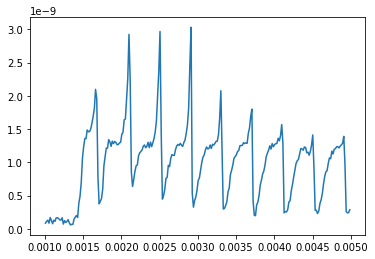

In [24]:
plt.plot(v_up[0,:], i_up[0, :])

In [44]:
m = np.mean(i_up, axis=0)
v = scipy.stats.moment(i_up, moment=2, axis=0)
sig = np.sqrt(v)

voltage_m = np.mean(v_up, axis=0)
voltage_v = scipy.stats.moment(v_up, moment=2, axis=0)
v_sig = np.sqrt(voltage_v)

Text(0.5, 1.0, 'IV characteristic with standard deviation of 1e4 samples')

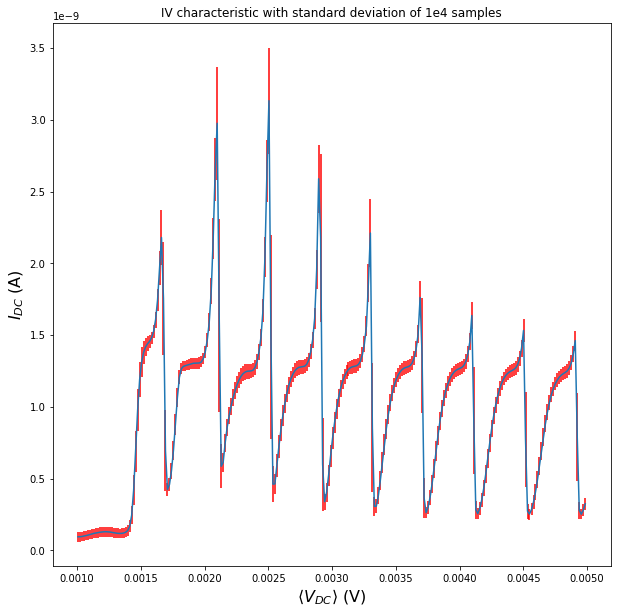

In [73]:
plt.figure(figsize=(10,10))

plt.errorbar(voltage_m, y=m, yerr = sig, ecolor='r')


plt.xlim()

plt.ylabel(r'$I_{DC}$ (A)', fontsize= 16)
plt.xlabel(r'$\langle V_{DC} \rangle$ (V)', fontsize=16)
plt.title("IV characteristic with standard deviation of 1e4 samples")

Text(0.5, 1.0, 'Standard deviation in current as a function of voltage bias')

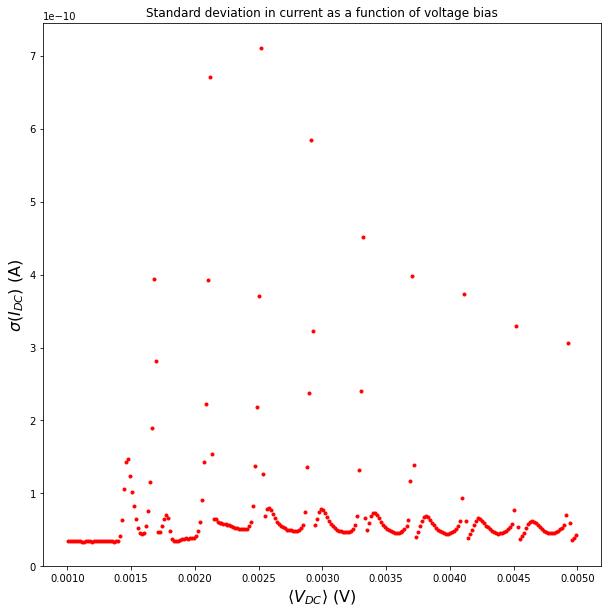

In [53]:
plt.figure(figsize=(10,10))
plt.plot(voltage_m , sig, '.', c='r')
plt.ylabel(r'$\sigma (I_{DC})$ (A)', fontsize= 16)
plt.xlabel(r'$\langle V_{DC} \rangle$ (V)', fontsize=16)
plt.title("Standard deviation in current as a function of voltage bias")

Average SD in voltage = 1.296e-07 V


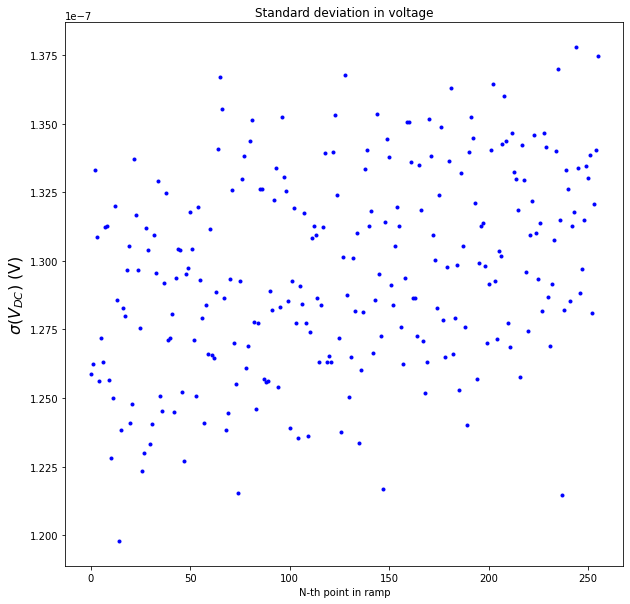

In [57]:
plt.figure(figsize=(10,10))
plt.plot( v_sig, '.', c='b')
plt.ylabel(r'$\sigma (V_{DC})$ (V)', fontsize= 16)
plt.xlabel('N-th point in ramp')
plt.title("Standard deviation in voltage")
print("Average SD in voltage = %.3e V" %np.mean(v_sig))

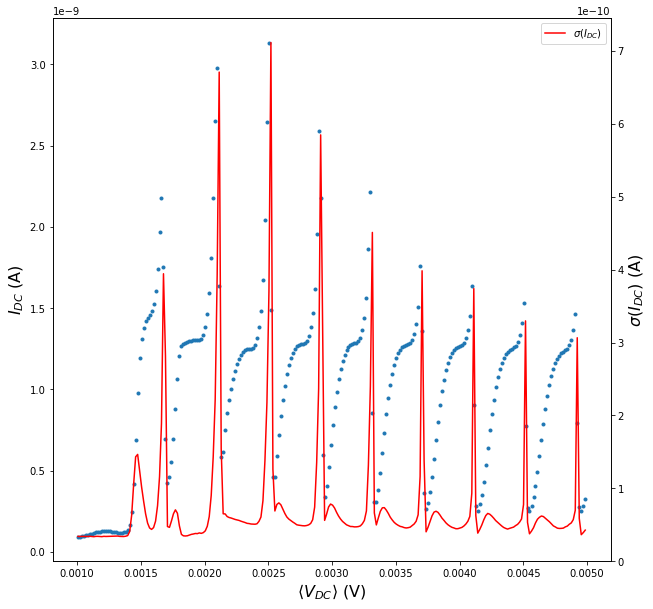

In [67]:
fig, ax1 = plt.subplots(figsize=(10,10))

ax1.plot(voltage_m, m, '.', label=r'$I_{DC}$')
ax1.set_xlabel(r'$\langle V_{DC} \rangle$ (V)', fontsize=16)
ax1.set_ylabel(r'$I_{DC}$ (A)', fontsize= 16)
ax2= ax1.twinx()

ax2.plot(voltage_m, sig, c='r', label=r'$\sigma (I_{DC})$')
ax2.set_ylabel(r'$\sigma (I_{DC})$ (A)', fontsize= 16)
ax2.legend()

In [68]:
dydx = np.gradient(m, voltage_m)

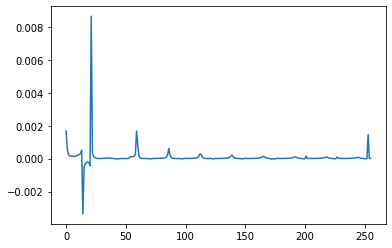

In [72]:
plt.plot(sig/(dydx+1e-9))